In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# the flow of code is as follows
# input image -> normalization -> dwt -> prediction of HF from LL -> mask from HF -> residual -> auto encoder -> probability model
# decoder -> decoded LL and HF residuals -> predicted HF -> combined HF -> idwt -> denormalization -> output image

In [ ]:
import pywt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from scipy import stats

In [ ]:
import os
list_of_files = []
# List all files in a directory using os.listdir
basepath = 'drive/MyDrive/NEF1'
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        list_of_files.append(entry)

In [ ]:
list_of_files

['r000da54ft (2).NEF',
 'r001d260dt.NEF',
 'r002fc3e2t.NEF',
 'r00444b95t.NEF',
 'r005f3e70t.NEF',
 'r00617aa1t.NEF',
 'r00679daet.NEF',
 'r006b0e4bt.NEF',
 'r006fcc20t.NEF',
 'r007f5116t.NEF',
 'r00816405t.NEF',
 'r00869422t.NEF',
 'r00879054t.NEF',
 'r008a2095t.NEF',
 'r008ed083t.NEF',
 'r00a940e1t.NEF',
 'r00b3931bt.NEF',
 'r00b8d4a2t.NEF',
 'r00c0995ft.NEF',
 'r00c4a543t.NEF',
 'r00d161b7t.NEF',
 'r00de2590t.NEF',
 'r01058910t.NEF',
 'r0108c383t.NEF',
 'r010cb248t.NEF',
 'r01170470t.NEF',
 'r01291f20t.NEF',
 'r01292fd8t.NEF',
 'r012b0f30t.NEF',
 'r012d1dbet.NEF',
 'r0141f0c9t.NEF',
 'r01474187t.NEF',
 'r0149a21ct.NEF',
 'r0150031ft.NEF',
 'r01511e3et.NEF',
 'r01559391t.NEF',
 'r015b453ft.NEF',
 'r0176fbcat.NEF',
 'r017904f0t.NEF',
 'r018ba134t.NEF',
 'r018e74fet.NEF',
 'r0191aaf4t.NEF',
 'r019eb1cbt.NEF',
 'r01a31693t.NEF',
 'r01a5f38at.NEF',
 'r01b3f004t.NEF',
 'r01b6aed6t.NEF',
 'r01c95f68t.NEF',
 'r01cbb7fdt.NEF',
 'r01cf60c7t.NEF',
 'r01d0b83bt.NEF',
 'r01d9da09t.NEF',
 'r01ef1

In [ ]:
def dwt(image_array):
  ll = np.zeros((128,128,3), dtype='float32')
  lh = np.zeros((128,128,3), dtype='float32')
  hl = np.zeros((128,128,3), dtype='float32')
  hh = np.zeros((128,128,3), dtype='float32')
  for k in range(3):
    for i in range(0,256,2):
      for j in range(0,256,2):
        ll[int(i/2)][int(j/2)][k] = ((image_array[i][j][k]) + (image_array[i][j+1][k]) + (image_array[i+1][j][k]) + (image_array[i+1][j+1][k]))/2
        lh[int(i/2)][int(j/2)][k] = ((image_array[i][j][k]) - (image_array[i][j+1][k]) + (image_array[i+1][j][k]) - (image_array[i+1][j+1][k]))/2
        hl[int(i/2)][int(j/2)][k] = ((image_array[i][j][k]) + (image_array[i][j+1][k]) - (image_array[i+1][j][k]) - (image_array[i+1][j+1][k]))/2
        hh[int(i/2)][int(j/2)][k] = ((image_array[i][j][k]) - (image_array[i][j+1][k]) - (image_array[i+1][j][k]) + (image_array[i+1][j+1][k]))/2
  return ll, lh, hl, hh

In [ ]:
data_frame = pd.DataFrame(columns = ['Image_red_mean', 'Image_green_mean', 'Image_blue_mean', 'Image_red_sd', 'Image_green_sd', 'Image_blue_sd'])
data_frame

,Image_red_mean,Image_green_mean,Image_blue_mean,Image_red_sd,Image_green_sd,Image_blue_sd


In [ ]:
def normalization(image_as_array):
    image_red = image_as_array[:,:,0]
    image_green = image_as_array[:,:,1]
    image_blue = image_as_array[:,:,2]
    mean_image_red = np.mean(image_red, axis=None)
    mean_image_green = np.mean(image_green, axis=None)
    mean_image_blue = np.mean(image_blue, axis=None)
    sd_image_red = np.std(image_red, axis=None)
    sd_image_green = np.std(image_green, axis=None)
    sd_image_blue = np.std(image_blue, axis=None)
    list_for_data_frame = []
    list_for_data_frame.append(mean_image_red)
    list_for_data_frame.append(mean_image_green)
    list_for_data_frame.append(mean_image_blue)
    list_for_data_frame.append(sd_image_red)
    list_for_data_frame.append(sd_image_green)
    list_for_data_frame.append(sd_image_blue)
    # adding the values to the dataframe
    data_frame.loc[len(data_frame.index)] = list_for_data_frame
    normalized_red_channel = (image_red - mean_image_red) / sd_image_red
    normalized_green_channel = (image_green - mean_image_green) / sd_image_green
    normalized_blue_channel = (image_blue - mean_image_blue) / sd_image_blue
    final_image = np.zeros((256,256,3), dtype='float32')
    final_image[:,:,0] = normalized_red_channel
    final_image[:,:,1] = normalized_green_channel
    final_image[:,:,2] = normalized_blue_channel
    return final_image

In [ ]:
list_of_ll = []
list_of_lh = []
list_of_hl = []
list_of_hh = []
for i in range(len(list_of_files)):
  direc = '/content/drive/MyDrive/NEF1/'+list_of_files[i]
  img = cv2.imread(direc)
  img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img2 = cv2.resize(img1, (256,256))
  image_as_array = (np.array(img2)).astype('float32')
  normalized_image = normalization(image_as_array)
  d = dwt(normalized_image)
  list_of_ll.append(d[0])
  list_of_lh.append(d[1])
  list_of_hl.append(d[2])
  list_of_hh.append(d[3])

In [ ]:
data_frame

,Image_red_mean,Image_green_mean,Image_blue_mean,Image_red_sd,Image_green_sd,Image_blue_sd
0,121.480972,122.216904,121.184311,65.234558,66.869545,70.558998
1,146.332825,124.186447,109.454483,82.006332,77.196762,76.112640
2,110.778793,101.060074,60.949783,76.282280,68.508522,55.691181
3,110.725800,94.858032,77.147202,77.686584,70.561058,66.117104
4,139.430618,109.798874,70.013519,84.241028,76.331757,66.265572
...,...,...,...,...,...,...
95,116.074570,109.969391,94.488632,68.348518,67.130653,69.632149
96,130.127365,112.987579,92.552216,71.143951,61.491661,62.293137
97,125.099655,131.177444,145.063507,56.668633,61.883080,84.794609
98,133.613235,102.052124,67.746979,65.783447,59.938686,48.561924


In [ ]:
np.count_nonzero(np.array(list_of_lh[0]))

40484

In [ ]:
def denormalization(image_to_be_denormalized, i):
    image_red = image_to_be_denormalized[:,:,0]
    image_green = image_to_be_denormalized[:,:,1]
    image_blue = image_to_be_denormalized[:,:,2]
    denormalized_red_channel = (image_red * data_frame['Image_red_sd'][i]) + data_frame['Image_red_mean'][i]
    denormalized_green_channel = (image_green * data_frame['Image_green_sd'][i]) + data_frame['Image_green_mean'][i]
    denormalized_blue_channel = (image_blue * data_frame['Image_blue_sd'][i]) + data_frame['Image_blue_mean'][i]
    final_image = np.zeros((256,256,3), dtype='float32')
    final_image[:,:,0] = denormalized_red_channel
    final_image[:,:,1] = denormalized_green_channel
    final_image[:,:,2] = denormalized_blue_channel
    return final_image

In [ ]:
# neural network model for prediction of HF sub bands from LF sub band
from tensorflow.keras import models, layers
model = models.Sequential()
model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(128, 128, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(3, (5, 5), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 3)       9603      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 3)       12        
Total params: 220,175
Trainable params: 219,785
Non-trainable params: 390
________________________________________________

In [ ]:
from tensorflow.keras import metrics

In [ ]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=[metrics.RootMeanSquaredError()])
history = model.fit(np.array(list_of_ll), np.array(list_of_lh), validation_split=0.05, epochs=20)

Epoch 1/20
3/3 [==============================] - 53s 17s/step - loss: 0.9448 - root_mean_squared_error: 0.9720 - val_loss: 0.1209 - val_root_mean_squared_error: 0.3477
Epoch 2/20
3/3 [==============================] - 51s 17s/step - loss: 0.8528 - root_mean_squared_error: 0.9235 - val_loss: 0.1072 - val_root_mean_squared_error: 0.3274
Epoch 3/20
3/3 [==============================] - 52s 17s/step - loss: 0.8271 - root_mean_squared_error: 0.9095 - val_loss: 0.0861 - val_root_mean_squared_error: 0.2933
Epoch 4/20
3/3 [==============================] - 51s 17s/step - loss: 0.8113 - root_mean_squared_error: 0.9007 - val_loss: 0.0912 - val_root_mean_squared_error: 0.3020
Epoch 5/20
3/3 [==============================] - 51s 17s/step - loss: 0.8000 - root_mean_squared_error: 0.8944 - val_loss: 0.0877 - val_root_mean_squared_error: 0.2962
Epoch 6/20
3/3 [==============================] - 52s 17s/step - loss: 0.7889 - root_mean_squared_error: 0.8882 - val_loss: 0.0984 - val_root_mean_squared_

In [ ]:
predicted_lh = model.predict(np.array(list_of_ll))

In [ ]:
np.count_nonzero(predicted_lh[0])

49152

In [ ]:
test_image = Image.fromarray((predicted_lh[0] * 255).astype('uint8'), 'RGB')
test_image.show()

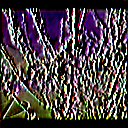

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(predicted_lh[0] * 255)

In [ ]:
np.amin(predicted_lh[0])

-0.36921927

In [ ]:
model1 = models.Sequential()
model1.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(128, 128, 3), padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(3, (5, 5), activation='relu', padding='same'))
model1.add(layers.BatchNormalization())

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 64)      4864      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 128)     204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 3)       9603      
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 3)       12        
Total params: 220,175
Trainable params: 219,785
Non-trainable params: 390
______________________________________________

In [ ]:
model1.compile(optimizer='adam',
              loss='mse',
              metrics=[metrics.RootMeanSquaredError()])
history1 = model1.fit(np.array(list_of_ll), np.array(list_of_hl), validation_split=0.05, epochs=20)

Epoch 1/20
3/3 [==============================] - 52s 17s/step - loss: 0.9419 - root_mean_squared_error: 0.9705 - val_loss: 0.1031 - val_root_mean_squared_error: 0.3212
Epoch 2/20
3/3 [==============================] - 52s 17s/step - loss: 0.8399 - root_mean_squared_error: 0.9165 - val_loss: 0.0953 - val_root_mean_squared_error: 0.3087
Epoch 3/20
3/3 [==============================] - 51s 17s/step - loss: 0.8109 - root_mean_squared_error: 0.9005 - val_loss: 0.0826 - val_root_mean_squared_error: 0.2874
Epoch 4/20
3/3 [==============================] - 51s 17s/step - loss: 0.7927 - root_mean_squared_error: 0.8904 - val_loss: 0.0709 - val_root_mean_squared_error: 0.2662
Epoch 5/20
3/3 [==============================] - 51s 17s/step - loss: 0.7800 - root_mean_squared_error: 0.8832 - val_loss: 0.0658 - val_root_mean_squared_error: 0.2565
Epoch 6/20
3/3 [==============================] - 51s 17s/step - loss: 0.7699 - root_mean_squared_error: 0.8774 - val_loss: 0.0693 - val_root_mean_squared_

In [ ]:
predicted_hl = model1.predict(np.array(list_of_ll))

In [ ]:
np.count_nonzero(predicted_hl[0])

49152

In [ ]:
np.amax(predicted_hl[0])

3.5358262

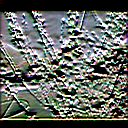

In [ ]:
cv2_imshow(predicted_hl[0] * 255)

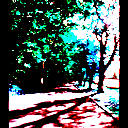

In [ ]:
cv2_imshow(np.array(list_of_ll[99]) * 255)

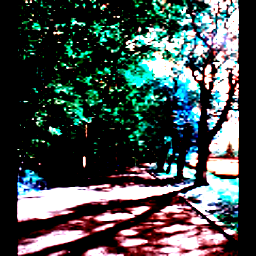

In [ ]:
cv2_imshow(normalized_image * 255)

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(128, 128, 3), padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(3, (5, 5), activation='relu', padding='same'))
model2.add(layers.BatchNormalization())

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 64)      4864      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 128)     204928    
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 3)       9603      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 3)       12        
Total params: 220,175
Trainable params: 219,785
Non-trainable params: 390
______________________________________________

In [ ]:
model2.compile(optimizer='adam',
              loss='mse',
              metrics=[metrics.RootMeanSquaredError()])
history2 = model2.fit(np.array(list_of_ll), np.array(list_of_hh), validation_split=0.05, epochs=20)

Epoch 1/20
3/3 [==============================] - 52s 17s/step - loss: 0.9912 - root_mean_squared_error: 0.9956 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 2/20
3/3 [==============================] - 51s 17s/step - loss: 0.9682 - root_mean_squared_error: 0.9840 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1002
Epoch 3/20
3/3 [==============================] - 51s 17s/step - loss: 0.9560 - root_mean_squared_error: 0.9778 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1206
Epoch 4/20
3/3 [==============================] - 51s 17s/step - loss: 0.9464 - root_mean_squared_error: 0.9728 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1267
Epoch 5/20
3/3 [==============================] - 51s 17s/step - loss: 0.9371 - root_mean_squared_error: 0.9681 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1479
Epoch 6/20
3/3 [==============================] - 51s 17s/step - loss: 0.9313 - root_mean_squared_error: 0.9651 - val_loss: 0.0307 - val_root_mean_squared_

In [ ]:
predicted_hh = model2.predict(np.array(list_of_ll))

In [ ]:
np.count_nonzero(predicted_hh[0])

49152

In [ ]:
np.amax(predicted_hh[0])

3.5242283

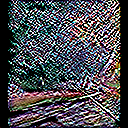

In [ ]:
cv2_imshow(predicted_hh[99]*255)

In [ ]:
print('LH : ', predicted_lh.shape, ' HL : ', predicted_hl.shape, ' HH : ', predicted_hh.shape)

LH :  (100, 128, 128, 3)  HL :  (100, 128, 128, 3)  HH :  (100, 128, 128, 3)


In [ ]:
l1 = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(predicted_lh)
l3 = (layers.BatchNormalization())(l1)
l2 = layers.Conv2D(128, (5, 5), activation='relu', padding='same')(l3)
l4 = (layers.BatchNormalization())(l2)
l5 = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(l4)
mask_for_lh = (layers.BatchNormalization())(l5)
mask_for_lh.shape

TensorShape([100, 128, 128, 3])

In [ ]:
l1 = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(predicted_hl)
l3 = (layers.BatchNormalization())(l1)
l2 = layers.Conv2D(128, (5, 5), activation='relu', padding='same')(l3)
l4 = (layers.BatchNormalization())(l2)
l5 = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(l4)
mask_for_hl = (layers.BatchNormalization())(l5)
mask_for_hl.shape

TensorShape([100, 128, 128, 3])

In [ ]:
l1 = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(predicted_hh)
l3 = (layers.BatchNormalization())(l1)
l2 = layers.Conv2D(128, (5, 5), activation='relu', padding='same')(l3)
l4 = (layers.BatchNormalization())(l2)
l5 = layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(l4)
mask_for_hh = (layers.BatchNormalization())(l5)
mask_for_hh.shape

TensorShape([100, 128, 128, 3])

In [ ]:
np.amin(mask_for_hh[0])

0.4048739

In [ ]:
# calculating the residuals for HF sub bands
lh_residual = np.array(list_of_lh) - (mask_for_lh.numpy() * predicted_lh)
hl_residual = np.array(list_of_hl) - (mask_for_hl.numpy() * predicted_hl)
hh_residual = np.array(list_of_hh) - (mask_for_hh.numpy() * predicted_hh)

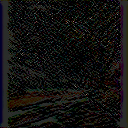

In [ ]:
cv2_imshow(hh_residual[99]*255)

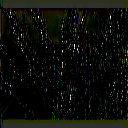

In [ ]:
cv2_imshow(lh_residual[0]*255)

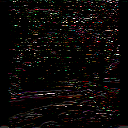

In [ ]:
cv2_imshow(hl_residual[99]*255)

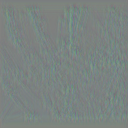

In [ ]:
cv2_imshow(mask_for_lh.numpy()[0] * 255)

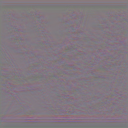

In [ ]:
cv2_imshow(mask_for_hl.numpy()[0] * 255)

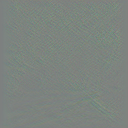

In [ ]:
cv2_imshow(mask_for_hh.numpy()[99] * 255)

In [ ]:
def residual_block(encoder_input):
    l1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_input)
    l2 = (layers.BatchNormalization())(l1)
    l3 = layers.Conv2D(128, (3, 3), padding='same')(l2)
    l4 = (layers.BatchNormalization())(l3)
    return encoder_input + l4

In [ ]:
def residual_block1(encoder_input):
    l1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_input)
    l2 = (layers.BatchNormalization())(l1)
    l3 = layers.Conv2D(128, (3, 3), padding='same')(l2)
    l4 = (layers.BatchNormalization())(l3)
    return encoder_input + l4

In [ ]:
sub_band = layers.Input(shape = (100,128,128,3))
def encoder(sub_band):
    l1 = layers.Conv2D(64, (5, 5), activation='relu', padding='same', strides=(2, 2))(sub_band)
    il1 = (layers.BatchNormalization())(l1)
    l2 = layers.Conv2D(128, (5, 5), activation='relu', padding='same', strides=(2, 2))(il1)
    il2 = (layers.BatchNormalization())(l2)
    
    l3 = residual_block(il2)
    l4 = residual_block(l3)
    l5 = residual_block(l4)
    
    junction1 = l5 + il2
    
    l6 = residual_block(junction1)
    l7 = residual_block(l6)
    l8 = residual_block(l7)
    
    junction2 = l8 + junction1
    
    l9 = residual_block(junction2)
    l10 = residual_block(l9)
    l11 = residual_block(l10)
    
    junction3 = l11 + junction2
    
    l12 = residual_block(junction3)
    l13 = residual_block(l12)
    l14 = residual_block(l13)
    
    junction4 = l14 + junction3
    
    l15 = residual_block(junction4)
    l16 = residual_block(l5)
    l17 = residual_block(l6)
    
    junction5 = l17 + junction4 +il2
    
    return junction5

In [ ]:
quantized_codes_1 = layers.Input(shape = (100,16,16,64))
def decoder(quantized_codes_1):
    l1 = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2), input_shape=(100,16,16,64))(quantized_codes_1)
    il1 = (layers.BatchNormalization())(l1)
    
    l2 = residual_block1(il1)
    l3 = residual_block1(l2)
    l4= residual_block1(l3)
    
    junction1 = l4 + il1
    
    l5 = residual_block1(junction1)
    l6 = residual_block1(l5)
    l7 = residual_block1(l6)
    
    junction2 = l7 + junction1
    
    l8 = residual_block1(junction2)
    l9 = residual_block1(l8)
    l10 = residual_block1(l9)
    
    junction3 = l10 + junction2
    
    l11 = residual_block1(junction3)
    l12 = residual_block1(l11)
    l13 = residual_block1(l12)
    
    junction4 =  l13 + junction3 + il1
    
    l14 = residual_block1(junction4)
    l15 = residual_block1(l14)
    l16 = residual_block1(l5)
    
    junction5 = l16 + junction4
    
    l17 = layers.Conv2DTranspose(128, (5, 5), activation='relu', padding='same', strides=(2, 2))(junction5)
    il17 = (layers.BatchNormalization())(l17)
    l18 = layers.Conv2DTranspose(3, (5, 5), padding='same', strides=(2, 2))(il17)
    il18 = (layers.BatchNormalization())(l18)
    
    return il18

In [ ]:
output = encoder(np.array(list_of_ll))

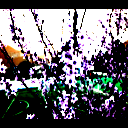

In [ ]:
cv2_imshow((np.array(list_of_ll)[0]) *255)

In [ ]:
output.shape

TensorShape([100, 32, 32, 128])

In [ ]:
output[0,:,:,0]

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[ -2.9288683 ,  -0.33351013,  -4.5050364 , ...,  -6.1668196 ,
          0.5241178 ,   1.4365982 ],
       [ -0.70219827,   3.9021347 ,   5.0207686 , ...,   0.08165789,
          1.8555123 ,   1.7345403 ],
       [ -8.745307  ,  -6.66488   , -14.883854  , ...,   1.7193854 ,
         -1.996425  ,   2.6190968 ],
       ...,
       [  3.0242858 ,   8.046167  ,   7.3481107 , ...,   3.7711825 ,
          8.08256   ,   7.16012   ],
       [ -1.0000196 ,   0.31613547,   4.590428  , ...,   5.2587566 ,
          4.4582214 ,  10.509371  ],
       [  7.9605684 ,   9.1876955 ,  12.277035  , ...,  12.256678  ,
         10.67182   ,  14.109138  ]], dtype=float32)>

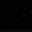

In [ ]:
cv2_imshow(output[0,:,:,0].numpy())

In [ ]:
def importance_map(enc_output):
  l2 = (layers.Conv2D(64, (5, 5), padding='same', strides=(2, 2), activation='sigmoid'))(enc_output)
  return l2

In [ ]:
np.amax(importance_map(output).numpy())

1.0

In [ ]:
decoded = decoder(output)

In [ ]:
decoded.shape

TensorShape([100, 256, 256, 3])

In [ ]:
np.mean(decoded[0,:,:,:].numpy())

3.634694

In [ ]:
cv2_imshow(decoded[99,:,:,:].numpy()*255)

In [ ]:
np.amax(decoded[0,:,:,:].numpy())

146.6647

In [ ]:
di = denormalization(decoded[0,:,:,:].numpy(), 0)

In [ ]:
cv2_imshow(di)

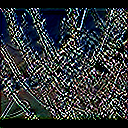

In [ ]:
cv2_imshow(predicted_hh[0] * 255)

In [ ]:
output.shape

TensorShape([100, 32, 32, 128])

In [ ]:
encoded_images = output.numpy()
encoded_images.shape

(100, 32, 32, 128)

In [ ]:
filtered_images = importance_map(encoded_images).numpy()
filtered_images.shape

(100, 16, 16, 64)

In [ ]:
cv2_imshow(filtered_images[0,:,:,0] * 255)

In [ ]:
quantized_images = quantizer(filtered_images)
quantized_images.shape

(100, 16, 16, 64)

In [ ]:
cv2_imshow(quantized_images[0,:,:,0] * 255)

In [ ]:
encoded_images[0][0,0,0]

-2.9288683

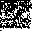

In [ ]:
cv2_imshow(encoded_images[0,:,:,0] * 255)

In [ ]:
np.amin(encoded_images[0,:,:,0])

-16.303904

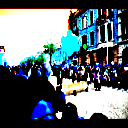

In [ ]:
cv2_imshow((np.array(list_of_ll)[55]) *255)

In [ ]:
# quantization for one image trial
from sklearn import cluster
one_d_image = encoded_images[0].ravel().reshape((-1,1))
k_means = cluster.KMeans(n_clusters=6, n_init=2)
k_means.fit(one_d_image)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_
values

array([  0.7071769,  23.784437 , -13.227102 ,   6.129201 ,  13.039173 ,
        -4.8928523], dtype=float32)

In [ ]:
image_compressed = np.choose(labels, values)
image_compressed.shape = encoded_images[0].shape

In [ ]:
image_compressed.shape

(32, 32, 128)

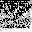

In [ ]:
cv2_imshow(image_compressed[:,:,0] * 255)

In [ ]:
quantized_codes = np.zeros((100,16,16,64))

In [ ]:
def quantizer(encoded_images):
  image_array = tf.make_ndarray(encoded_images)
  for i in range (100):
    one_d_image = np.ravel(image_array[i]).reshape((-1,1))
    k_means = cluster.KMeans(n_clusters=6)
    k_means.fit(one_d_image)
    values = k_means.cluster_centers_.squeeze()
    labels = k_means.labels_
    image_compressed = np.choose(labels, values)
    image_compressed.shape = encoded_images[i].shape
    quantized_codes[i] = image_compressed
  return quantized_codes

In [ ]:
qc = quantizer(encoded_images)

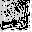

In [ ]:
cv2_imshow(qc[99,:,:,0] * 255)

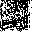

In [ ]:
cv2_imshow(encoded_images[99,:,:,0] * 255)

In [ ]:
# probability coding
qc1 = np.moveaxis(qc, -1, 0)
qc1.shape

(128, 100, 32, 32)

In [ ]:
def probability_model(qc):
  l1 = layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu')(qc)
  l2 = (layers.BatchNormalization())(l1)
  l3 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(l2)
  l4 = (layers.BatchNormalization())(l3)
  l5 = layers.Conv3D(64, (3, 3, 3), padding='same')(l4)
  l6 = layers.Conv3D(6, (3, 3, 3), activation='relu', padding='same')(l5 + l2)
  l7 = layers.Softmax()(l6)
  return l7

In [ ]:
pc = probability_model(quantized_images).numpy()

In [ ]:
pc.shape

(100, 16, 16, 6)

In [ ]:
cv2_imshow(quantized_images[50,:,:,0] * 255)

In [ ]:
decoding_after_prob = decoder(quantized_images)

In [ ]:
decoding_after_prob.shape

TensorShape([100, 128, 128, 3])

In [ ]:
dci = decoding_after_prob.numpy()

In [ ]:
cv2_imshow(dci[0,:,:,0] * 255)

In [ ]:
dci[0,:,:,:].shape

(128, 128, 3)

In [ ]:
idwt_image = np.zeros((64,64,3))
for k in range(3):
    for i in range(0,128,2):
      for j in range(0,128,2):
        idwt_image[int(i/2)][int(j/2)][k] = ((dci[0,:,:,:][i][j][k]) + (dci[0,:,:,:][i][j+1][k]) + (dci[0,:,:,:][i+1][j][k]) + (dci[0,:,:,:][i+1][j+1][k]))/2
cv2_imshow(idwt_image * 255)

In [ ]:
reconstructed_image = denormalization(idwt_image,0)

In [ ]:
reconstructed_image.shape

(64, 64, 3)

In [ ]:
cv2_imshow(reconstructed_image/2)

In [ ]:
ddd = denormalization(dci[0,:,:,:], 0)

In [ ]:
cv2_imshow(ddd[:,:,0]/75)

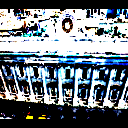

In [ ]:
cv2_imshow(np.array(list_of_ll[21]) * 255)

In [ ]:
# building a model
encoder_model = models.Model(sub_band, encoder(sub_band))

In [ ]:
encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 128, 12 0                                            
__________________________________________________________________________________________________
conv2d_305 (Conv2D)             (None, 100, 64, 64,  4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_317 (BatchN (None, 100, 64, 64,  256         conv2d_305[0][0]                 
__________________________________________________________________________________________________
conv2d_306 (Conv2D)             (None, 100, 32, 32,  204928      batch_normalization_317[0][0]    
____________________________________________________________________________________________

In [ ]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 16, 16, 64)] 0                                            
__________________________________________________________________________________________________
conv2d_transpose_25 (Conv2DTran (None, 32, 32, 128)  73856       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_382 (BatchN (None, 32, 32, 128)  512         conv2d_transpose_25[0][0]        
__________________________________________________________________________________________________
conv2d_367 (Conv2D)             (None, 32, 32, 128)  147584      batch_normalization_382[0][0]    
____________________________________________________________________________________________

In [ ]:
quantized_images.shape

(100, 16, 16, 64)

In [ ]:
sub_band = layers.Input(shape = (128,128,3))
l1 = layers.Conv2D(64, (5, 5), activation='relu', padding='same', strides=(2, 2))(sub_band)
il1 = (layers.BatchNormalization())(l1)
l2 = layers.Conv2D(128, (5, 5), activation='relu', padding='same', strides=(2, 2))(il1)
il2 = (layers.BatchNormalization())(l2)
    
l3 = residual_block(il2)
l4 = residual_block(l3)
l5 = residual_block(l4)
    
junction1 = l5 + il2
    
l6 = residual_block(junction1)
l7 = residual_block(l6)
l8 = residual_block(l7)
    
junction2 = l8 + junction1
    
l9 = residual_block(junction2)
l10 = residual_block(l9)
l11 = residual_block(l10)
    
junction3 = l11 + junction2
    
l12 = residual_block(junction3)
l13 = residual_block(l12)
l14 = residual_block(l13)
    
junction4 = l14 + junction3
    
l15 = residual_block(junction4)
l16 = residual_block(l5)
l17 = residual_block(l6)
    
junction5 = l17 + junction4 +il2
    
l18 = (layers.Conv2D(64, (5, 5), padding='same', strides=(2, 2), activation='sigmoid'))(junction5)



# decoding section
dl1 = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(l18)
dil1 = (layers.BatchNormalization())(dl1)
    
dl2 = residual_block1(dil1)
dl3 = residual_block1(dl2)
dl4= residual_block1(dl3)
    
djunction1 = dl4 + dil1
    
dl5 = residual_block1(djunction1)
dl6 = residual_block1(dl5)
dl7 = residual_block1(dl6)
    
djunction2 = dl7 + djunction1
    
dl8 = residual_block1(djunction2)
dl9 = residual_block1(dl8)
dl10 = residual_block1(dl9)
    
djunction3 = dl10 + djunction2
    
dl11 = residual_block1(djunction3)
dl12 = residual_block1(dl11)
dl13 = residual_block1(dl12)
    
djunction4 =  dl13 + djunction3 + dil1
    
dl14 = residual_block1(djunction4)
dl15 = residual_block1(dl14)
dl16 = residual_block1(dl5)
    
djunction5 = dl16 + djunction4
    
dl17 = layers.Conv2DTranspose(128, (5, 5), activation='relu', padding='same', strides=(2, 2))(djunction5)
dil17 = (layers.BatchNormalization())(dl17)
dl18 = layers.Conv2DTranspose(3, (5, 5), padding='same', strides=(2, 2))(dil17)
dil18 = (layers.BatchNormalization())(dl18)


In [ ]:
complete_model = models.Model(sub_band, dil18)

In [ ]:
complete_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1087 (Conv2D)            (None, 64, 64, 64)   4864        input_26[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1121 (Batch (None, 64, 64, 64)   256         conv2d_1087[0][0]                
__________________________________________________________________________________________________
conv2d_1088 (Conv2D)            (None, 32, 32, 128)  204928      batch_normalization_1121[0][0]   
____________________________________________________________________________________________

In [ ]:
complete_model.compile(optimizer='adam',
              loss='mse',
              metrics=[metrics.RootMeanSquaredError()])
exce = complete_model.fit(np.array(list_of_ll), np.array(list_of_ll), validation_split=0.05, epochs=50)

Epoch 1/50
3/3 [==============================] - 109s 34s/step - loss: 1.6418 - root_mean_squared_error: 1.2813 - val_loss: 5.9697 - val_root_mean_squared_error: 2.4433
Epoch 2/50
3/3 [==============================] - 101s 34s/step - loss: 1.4225 - root_mean_squared_error: 1.1927 - val_loss: 6.1868 - val_root_mean_squared_error: 2.4873
Epoch 3/50
3/3 [==============================] - 101s 34s/step - loss: 1.3428 - root_mean_squared_error: 1.1588 - val_loss: 12.1669 - val_root_mean_squared_error: 3.4881
Epoch 4/50
3/3 [==============================] - 101s 34s/step - loss: 1.2899 - root_mean_squared_error: 1.1357 - val_loss: 7.5871 - val_root_mean_squared_error: 2.7545
Epoch 5/50
3/3 [==============================] - 101s 34s/step - loss: 1.2605 - root_mean_squared_error: 1.1227 - val_loss: 9.4058 - val_root_mean_squared_error: 3.0669
Epoch 6/50
3/3 [==============================] - 101s 34s/step - loss: 1.2302 - root_mean_squared_error: 1.1092 - val_loss: 8.0358 - val_root_mean_s

In [ ]:
predicted_images = complete_model.predict(np.array(list_of_ll))

In [ ]:
predicted_images.dtype

dtype('float32')

In [ ]:
predicted_images[0].shape

(128, 128, 3)

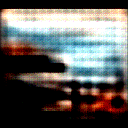

In [ ]:
cv2_imshow(predicted_images[90] * 255)

In [ ]:
idwt_image = np.zeros((64,64,3))
for k in range(3):
    for i in range(0,128,2):
      for j in range(0,128,2):
        idwt_image[int(i/2)][int(j/2)][k] = ((predicted_images[90][i][j][k]) + (predicted_images[90][i][j+1][k]) + (predicted_images[90][i+1][j][k]) + (predicted_images[90][i+1][j+1][k]))/2

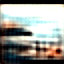

In [ ]:
cv2_imshow(denormalization(idwt_image,90))

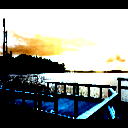

In [ ]:
cv2_imshow(np.array(list_of_ll[90])* 255 )


In [ ]:
print(l18)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name=None), name='conv2d_1119/Sigmoid:0', description="created by layer 'conv2d_1119'")


In [ ]:
def denormalization1(image_to_be_denormalized, i):
    image_red = image_to_be_denormalized[:,:,0]
    image_green = image_to_be_denormalized[:,:,1]
    image_blue = image_to_be_denormalized[:,:,2]
    denormalized_red_channel = (image_red * data_frame['Image_red_sd'][i]) + data_frame['Image_red_mean'][i]
    denormalized_green_channel = (image_green * data_frame['Image_green_sd'][i]) + data_frame['Image_green_mean'][i]
    denormalized_blue_channel = (image_blue * data_frame['Image_blue_sd'][i]) + data_frame['Image_blue_mean'][i]
    final_image = np.zeros((256,256,3), dtype='float32')
    final_image[:,:,0] = denormalized_red_channel
    final_image[:,:,1] = denormalized_green_channel
    final_image[:,:,2] = denormalized_blue_channel
    return final_image

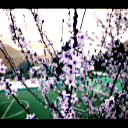

In [ ]:
reconstr_img = denormalization1(np.array(list_of_ll[0]),0)
cv2_imshow(reconstr_img)

In [ ]:
reconstr_img.shape

(128, 128, 3)

In [ ]:
resized = cv2.resize(reconstr_img, (256,256), interpolation = cv2.INTER_AREA)

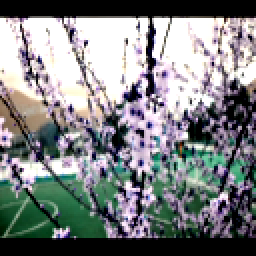

In [ ]:
cv2_imshow(resized)

In [ ]:
list_of_images = []
for i in range(len(list_of_files)):
  direc = '/content/drive/MyDrive/NEF1/'+list_of_files[i]
  img = cv2.imread(direc)
  img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img2 = cv2.resize(img1, (256,256))
  list_of_images.append(img2)

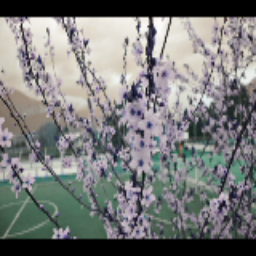

In [ ]:
cv2_imshow(np.array(list_of_images[0]))

In [ ]:
from skimage.measure import compare_ssim
(score,diff) = compare_ssim(resized, np.array(list_of_images[0]), full=True , multichannel=True)
print(score)

0.4728274504112367


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [ ]:

direct = '/content/drive/MyDrive/JPEG/final_compressed_jpeg.jpg'
timg = cv2.imread(direct)
timg1 = cv2.cvtColor(timg, cv2.COLOR_BGR2RGB)
timg2 = cv2.resize(timg1, (256,256))

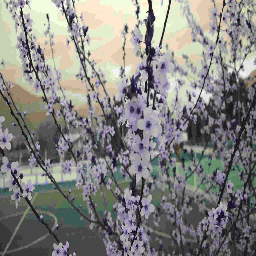

In [ ]:
cv2_imshow(timg2)

In [ ]:
from skimage.measure import compare_ssim
(score,diff) = compare_ssim(timg2, np.array(list_of_images[0]), full=True , multichannel=True)
print(score)

0.18585915283104107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


In [ ]:
save_image = cv2.imwrite("/content/drive/MyDrive/JPEG/reconstructed_image.png", resized)

In [ ]:
original_resized_image = cv2.imwrite("/content/drive/MyDrive/JPEG/original_resized_image.png", np.array(list_of_images[0]))

In [ ]:
from google.colab.patches import cv2_imshow

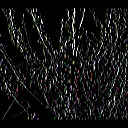

In [ ]:
cv2_imshow(np.array(list_of_lh[0]) * 255)

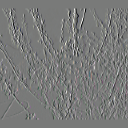

In [ ]:
reconstr_img_1 = denormalization1(np.array(list_of_lh[0]),0)
cv2_imshow(reconstr_img_1)

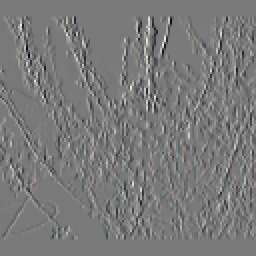

In [ ]:
resized_1 = cv2.resize(reconstr_img_1, (256,256), interpolation = cv2.INTER_AREA)
cv2_imshow(resized_1)

In [ ]:
combined_image = reconstr_img + reconstr_img_1
combined_image_1 = denormalization1(combined_image,0)
cv2_imshow(combined_image_1)

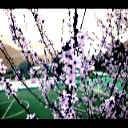

In [ ]:
ci = np.array(list_of_ll[0]) + np.array(list_of_lh[0])
deci = denormalization1(ci,0)
cv2_imshow(deci)

In [ ]:
some_random_image = cv2.resize(np.array(list_of_ll[0]), (256,256)) + cv2.resize(np.array(list_of_lh[0]), (256,256)) + cv2.resize(np.array(list_of_hl[0]), (256,256)) + cv2.resize(np.array(list_of_hh[0]), (256,256)) 

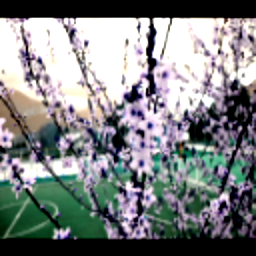

In [ ]:
some_random_image_1 = denormalization1(some_random_image, 0)
cv2_imshow(some_random_image_1)

In [ ]:
from skimage.measure import compare_ssim
(score,diff) = compare_ssim(some_random_image_1, np.array(list_of_images[0]), full=True , multichannel=True)
print(score)

0.622632948561795


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


In [ ]:
import pywt

In [ ]:
cA, cD = pywt.dwt(np.array(list_of_images[0]), wavelet='haar')

In [ ]:
cA.shape

(256, 256, 2)

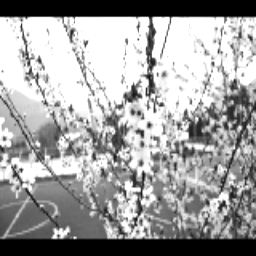

In [ ]:
cv2_imshow(cA[:,:,1])

In [ ]:
np.amax(cA[:,:,1])

359.21024484276614

In [ ]:
rei = pywt.idwt(cA,cD, wavelet='haar')
rei[:,:,0].shape

(256, 256)

In [ ]:
(score,diff) = compare_ssim(cA[:,:,0], cA[:,:,1], full=True , multichannel=True)
score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


0.906734669902159

In [ ]:
np.array(list_of_images[0]).shape

(256, 256, 3)

In [ ]:
check_matrix_A, check_matrix_D = pywt.dwt(list_of_images[0][:,:,0], wavelet='haar')
check_matrix_A.shape

(256, 128)

In [ ]:
dwt1t_ll, dwt1t_hh = pywt.dwt2(np.array(list_of_images[0][:,:,0]), wavelet='haar')
dwt1t_ll.shape

(128, 128)

In [ ]:
idwtre = pywt.idwt2((dwt1t_ll, dwt1t_hh), wavelet='haar')
idwtre.shape

(256, 256)

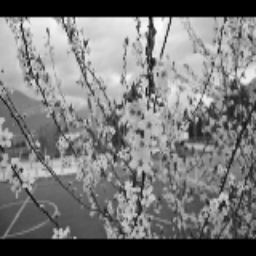

In [ ]:
cv2_imshow(idwtre)

In [ ]:
image_in_play = normalization(list_of_images[0])

In [ ]:
red_dwt1t_ll, red_dwt1t_hh = pywt.dwt2(image_in_play[:,:,0], wavelet='haar')
green_dwt1t_ll, green_dwt1t_hh = pywt.dwt2(image_in_play[:,:,1], wavelet='haar')
blue_dwt1t_ll, blue_dwt1t_hh = pywt.dwt2(image_in_play[:,:,2], wavelet='haar')

In [ ]:
red_idwt = pywt.idwt2((red_dwt1t_ll,red_dwt1t_hh), wavelet='haar')
green_idwt = pywt.idwt2((green_dwt1t_ll,green_dwt1t_hh), wavelet='haar')
blue_idwt = pywt.idwt2((blue_dwt1t_ll,blue_dwt1t_hh), wavelet='haar')
reimg = np.zeros((256,256,3))
reimg[:,:,0] = red_idwt
reimg[:,:,1] = green_idwt
reimg[:,:,2] = blue_idwt
denorm_image = denormalization(reimg, 0)
denorm_image.shape

(256, 256, 3)

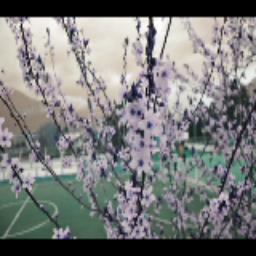

In [ ]:
cv2_imshow(denorm_image)

In [ ]:
(score,diff) = compare_ssim(denorm_image, np.array(list_of_images[0]), full=True , multichannel=True)
print(score)

In [ ]:
image_in_play.dtype

dtype('float32')

In [ ]:
from keras import backend as K
tensor = K.constant([1,2,34])
print(tensor.numpy())

[ 1.  2. 34.]


In [ ]:
from keras import layers
import tensorflow as tf

In [ ]:
from tf.compat.v1.estimator.experimental.KMeans

In [ ]:
sub_band = layers.Input(shape = (128,128,3))
l1 = layers.Conv2D(64, (5, 5), activation='relu', padding='same', strides=(2, 2), input_shape=(100,128,128,3))(sub_band)
il1 = (layers.BatchNormalization())(l1)
l2 = layers.Conv2D(128, (5, 5), activation='relu', padding='same', strides=(2, 2))(il1)
il2 = (layers.BatchNormalization())(l2)
    
l3 = residual_block(il2)
l4 = residual_block(l3)
l5 = residual_block(l4)
    
junction1 = l5 + il2
    
l6 = residual_block(junction1)
l7 = residual_block(l6)
l8 = residual_block(l7)
    
junction2 = l8 + junction1
    
l9 = residual_block(junction2)
l10 = residual_block(l9)
l11 = residual_block(l10)
    
junction3 = l11 + junction2
    
l12 = residual_block(junction3)
l13 = residual_block(l12)
l14 = residual_block(l13)
    
junction4 = l14 + junction3
    
l15 = residual_block(junction4)
l16 = residual_block(l5)
l17 = residual_block(l6)
    
junction5 = l17 + junction4 +il2
    
l18 = (layers.Conv2D(64, (5, 5), padding='same', strides=(2, 2), activation='sigmoid'))(junction5)



# decoding section
dl1 = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(l18)
dil1 = (layers.BatchNormalization())(dl1)
    
dl2 = residual_block1(dil1)
dl3 = residual_block1(dl2)
dl4= residual_block1(dl3)
    
djunction1 = dl4 + dil1
    
dl5 = residual_block1(djunction1)
dl6 = residual_block1(dl5)
dl7 = residual_block1(dl6)
    
djunction2 = dl7 + djunction1
    
dl8 = residual_block1(djunction2)
dl9 = residual_block1(dl8)
dl10 = residual_block1(dl9)
    
djunction3 = dl10 + djunction2
    
dl11 = residual_block1(djunction3)
dl12 = residual_block1(dl11)
dl13 = residual_block1(dl12)
    
djunction4 =  dl13 + djunction3 + dil1
    
dl14 = residual_block1(djunction4)
dl15 = residual_block1(dl14)
dl16 = residual_block1(dl5)
    
djunction5 = dl16 + djunction4
    
dl17 = layers.Conv2DTranspose(128, (5, 5), activation='relu', padding='same', strides=(2, 2))(djunction5)
dil17 = (layers.BatchNormalization())(dl17)
dl18 = layers.Conv2DTranspose(3, (5, 5), padding='same', strides=(2, 2))(dil17)
dil18 = (layers.BatchNormalization())(dl18)


In [ ]:
def quant(tensor):
  for i in (16):
    for j in (16):
      for k in (64):
        tensor[:,i,j,k] = 


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras import models, layers

In [ ]:
l17[:,1,1,1]

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.getitem_3')>